# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 04 : Analyse multivariée - Interactions et structures cachées

---

### Identité du document

* **Statut :** Phase 1 (exploration & prototypage)
* **Date de création :** 31 Décembre 2025
* **Dernière mise à jour :** 13 Janvier 2026
* **Dépendances notebooks :** Notebooks 0, 1, 2, 3

### Description

Ce notebook est dédié à une **analyse multivariée** visant à dépasser les relations bivariées simples pour explorer la **complexité réelle** des émissions de GES.
Il adopte une posture plus **exploratoire et créative** : formuler des hypothèses métier, tester des interactions, identifier des structures latentes (segments/archétypes), et évaluer la possibilité de réduire la dimensionnalité sans perdre l’essentiel de l’information.

### Objectifs principaux

1. **Tester** des hypothèses d’**interactions** (effets synergiques entre variables) et sélectionner celles qui apportent un gain.
2. **Structurer** un **blueprint de feature engineering** priorisé pour la phase de modélisation.

### Dépendances critiques

* `hydra` : Gestion de configuration (chemins, variables, paramètres d’analyse).
* `pandas`, `numpy` : Manipulation et préparation des données.
* `seaborn`, `matplotlib` : Visualisations multivariées (pairplot, FacetGrid, distributions).

---

# Table des Matières

* [Section 1 : Hypothèses d'interactions et tests](#section-1--hypothèses-dinteractions-et-tests)
* [Section 2 : Blueprint de Feature Engineering](#section-2--blueprint-de-feature-engineering)
---


# Loading des données 

In [ ]:
import sys, logging
from pathlib import Path

# Pour que les imports
PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

from utils.config_loader import load_config
from data.load_data import load_data_cleaned
from feature_engineering.build_features import run_feature_engineering_pipeline

# Chargement et logging
cfg = load_config() 

# Chargement des données
df = load_data_cleaned(cfg)      
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,IsMixedUse,Has_EnergyStarScore,IsZeroFloorReported,IsAggregatedCampus
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,12764.52930,1276453.0,False,Compliant,249.98,2.83,0,1,0,0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,51450.81641,5145082.0,False,Compliant,295.86,2.86,1,1,0,0
2,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,18112.13086,1811213.0,False,Compliant,286.43,4.67,0,1,0,0
3,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,88039.98438,8803998.0,False,Compliant,505.01,2.88,1,1,0,0
4,9,2016,Nonresidential COS,Other,West Precinct,810 Virginia St,Seattle,WA,98101.0,0660000560,...,47151.81641,4715182.0,False,Compliant,301.81,3.10,0,0,0,0


# Section 1 : Hypothèses d'interactions et tests

L’objectif de cette section est de tester de manière systématique des interactions “métier”, c’est-à-dire des combinaisons de variables qui ont un sens physique ou opérationnel dans un bâtiment. Une interaction est considérée comme prometteuse si une variable construite à partir de cette interaction présente une association plus forte avec les émissions que chacune des variables prises séparément. La logique est que, dans un système urbain complexe, certaines causes n’agissent pas additivement mais multiplicativement : l’effet d’une variable dépend du niveau d’une autre (taille, âge, etc.). Dans un premier temps, on utilise des tests simples basés sur corrélation et visualisation (scatter plots), non pas comme preuve causale, mais comme filtre pour identifier les interactions qui méritent d’être intégrées ensuite dans un modèle non linéaire ou un modèle avec termes d’interaction explicites.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

def corr_pair(x, y):
    """Retourne Pearson + Spearman (en ignorant NaN)."""
    s = pd.concat([x, y], axis=1).dropna()
    if len(s) < 3:
        return {"Pearson": np.nan, "Spearman": np.nan, "n": len(s)}
    return {
        "Pearson": pearsonr(s.iloc[:,0], s.iloc[:,1])[0],
        "Spearman": spearmanr(s.iloc[:,0], s.iloc[:,1])[0],
        "n": len(s)
    }

def scatter_xy(x, y, title, xlabel, ylabel, logx=False, logy=False):
    s = pd.concat([x, y], axis=1).dropna()
    plt.figure()
    plt.scatter(s.iloc[:,0], s.iloc[:,1], alpha=0.35, s=12)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

## 1.1 Age × ENERGYSTARScore : effet différencié de la performance selon l’âge

Cette hypothèse repose sur une intuition opérationnelle : dans un bâtiment ancien, il existe souvent une marge de progrès plus grande (enveloppe, systèmes HVAC, régulation, éclairage), donc un indicateur de performance ou de bonne exploitation peut avoir un effet plus “révélateur” que dans un bâtiment déjà récent et conforme à des codes plus stricts. Autrement dit, un bon score ENERGYSTAR dans un bâtiment vieux peut signaler une rénovation, une exploitation exemplaire ou un système modernisé ; alors que dans un bâtiment récent, le score peut être plus “facile” à atteindre et moins discriminant. Cette interaction est aussi justifiable parce que les scores type ENERGYSTAR sont des agrégats qui n’épousent pas toujours parfaitement les émissions réelles, surtout dans un réseau électrique décarboné : l’âge peut moduler la relation entre score et émissions via des choix de chauffage (gaz/vapeur) et de systèmes.

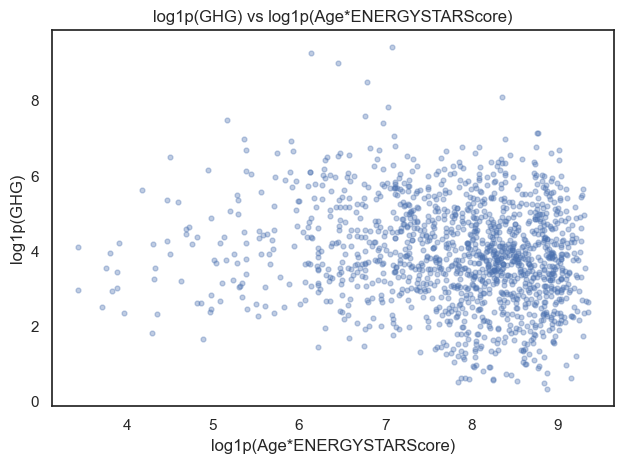

          X                      Y   Pearson  Spearman     n
0       GHG                    Age -0.083933 -0.163592  1395
1       GHG        ENERGYSTARScore -0.075789 -0.028642  1395
2       GHG         Age*ENERGYSTAR -0.094789 -0.159077  1395
3  log(GHG)             log1p(Age) -0.178256 -0.163592  1395
4  log(GHG)      log1p(ENERGYSTAR) -0.023299 -0.028642  1395
5  log(GHG)  log1p(Age*ENERGYSTAR) -0.152727 -0.159077  1395


In [14]:
# ---- colonnes
GHG = "TotalGHGEmissions"
YEAR = "YearBuilt"
ES = "ENERGYSTARScore"
YEAR_REF = 2016

df2 = df.copy()
df2 = df2.dropna(subset=[GHG, YEAR, ES])
df2 = df2[(df2[GHG] >= 0) & (df2[YEAR] > 0) & (df2[ES] > 0)]

df2["Age"] = YEAR_REF - df2[YEAR]
df2 = df2[df2["Age"] >= 0]

df2["Interaction_Age_ENERGY"] = df2["Age"] * df2[ES]

scatter_xy(
    x=np.log1p(df2["Interaction_Age_ENERGY"]),
    y=np.log1p(df2[GHG]),
    title="log1p(GHG) vs log1p(Age*ENERGYSTARScore)",
    xlabel="log1p(Age*ENERGYSTARScore)",
    ylabel="log1p(GHG)"
)

res = []
res.append({"X":"GHG", "Y":"Age", **corr_pair(df2[GHG], df2["Age"])})
res.append({"X":"GHG", "Y":"ENERGYSTARScore", **corr_pair(df2[GHG], df2[ES])})
res.append({"X":"GHG", "Y":"Age*ENERGYSTAR", **corr_pair(df2[GHG], df2["Interaction_Age_ENERGY"])})
res.append({"X":"log(GHG)", "Y":"log1p(Age)", **corr_pair(np.log1p(df2[GHG]), np.log1p(df2["Age"]))})
res.append({"X":"log(GHG)", "Y":"log1p(ENERGYSTAR)", **corr_pair(np.log1p(df2[GHG]), np.log1p(df2[ES]))})
res.append({"X":"log(GHG)", "Y":"log1p(Age*ENERGYSTAR)", **corr_pair(np.log1p(df2[GHG]), np.log1p(df2["Interaction_Age_ENERGY"]))})
print(pd.DataFrame(res))


Le tableau montre `corr(GHG, GFA)` ≈ **0.445 / 0.547**, alors que `corr(GHG, Age*GFA)` est plus faible à **0.317 / 0.362**. Même en log, `log(GHG)` vs `log(GFA)` est à **0.589**, alors que `log(GHG)` vs `log1p(Age*GFA)` est à **0.382**. Donc l’interaction “obsolescence × complexité des gros systèmes” n’émerge pas sous forme d’un signal simple corrélatif avec les émissions totales ; soit l’effet n’existe pas globalement, soit il est masqué par des facteurs dominants (usage, vapeur/gaz, rénovations), soit il est non monotone (très plausible). Le scatter que tu montres a une tendance globale positive, mais elle ressemble surtout à un effet “les grands bâtiments émettent plus” et non à une amplification nette par l’âge.

## 1.2 Age (2016 − YearBuilt) et interactions dérivées : hystérésis réglementaire et obsolescence système

L’âge est une variable dérivée simple mais souvent plus interprétable que l’année brute, parce qu’elle correspond mieux à l’idée de vieillissement des systèmes, de dérive des réglages, et de probabilité d’être construit sous un code énergétique ancien. L’hypothèse métier est que l’âge agit comme un facteur de risque énergétique et carbone, mais pas forcément de façon linéaire : certains bâtiments anciens ont été rénovés, d’autres non. Malgré cela, Age sert de “prior” utile.

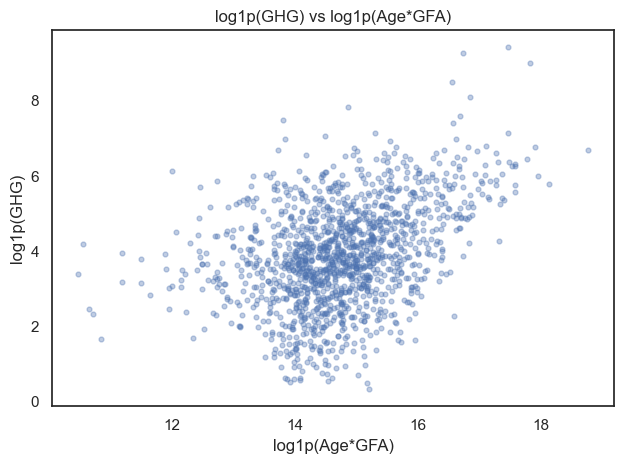

          X               Y   Pearson  Spearman     n
0       GHG             Age -0.083933 -0.163592  1395
1       GHG             GFA  0.445023  0.547310  1395
2       GHG         Age*GFA  0.316986  0.361656  1395
3  log(GHG)      log1p(Age) -0.178256 -0.163592  1395
4  log(GHG)        log(GFA)  0.589477  0.547310  1395
5  log(GHG)  log1p(Age*GFA)  0.382302  0.361656  1395


In [17]:
# ---- colonnes
GHG = "TotalGHGEmissions"
GFA = "PropertyGFATotal"
YEAR = "YearBuilt"
YEAR_REF = 2016

df5 = df.copy()
df5 = df5.dropna(subset=[GHG, GFA, YEAR])
df5 = df5[(df5[GHG] >= 0) & (df5[GFA] > 0) & (df5[YEAR] > 0)]

df5["Age"] = YEAR_REF - df5[YEAR]
df5 = df5[df5["Age"] >= 0]

df5["Age_x_GFA"] = df5["Age"] * df5[GFA]

scatter_xy(
    x=np.log1p(df5["Age_x_GFA"]),
    y=np.log1p(df5[GHG]),
    title="log1p(GHG) vs log1p(Age*GFA)",
    xlabel="log1p(Age*GFA)",
    ylabel="log1p(GHG)"
)

res = []
res.append({"X":"GHG", "Y":"Age", **corr_pair(df5[GHG], df5["Age"])})
res.append({"X":"GHG", "Y":"GFA", **corr_pair(df5[GHG], df5[GFA])})
res.append({"X":"GHG", "Y":"Age*GFA", **corr_pair(df5[GHG], df5["Age_x_GFA"])})
res.append({"X":"log(GHG)", "Y":"log1p(Age)", **corr_pair(np.log1p(df5[GHG]), np.log1p(df5["Age"]))})
res.append({"X":"log(GHG)", "Y":"log(GFA)", **corr_pair(np.log1p(df5[GHG]), np.log(df5[GFA]))})
res.append({"X":"log(GHG)", "Y":"log1p(Age*GFA)", **corr_pair(np.log1p(df5[GHG]), np.log1p(df5["Age_x_GFA"]))})
print(pd.DataFrame(res))


Le ratio `Gas/(Elec+1)` a un **Pearson quasi nul** (~0.02–0.08) mais un **Spearman ≈ 0.41**, et le nuage montre une énorme concentration près de zéro (bâtiments très peu gaz ou beaucoup électricité) et quelques points extrêmes très à droite. Ça explique l’écart : Spearman capte un ordre monotone (quand le ratio augmente, GHG tend à augmenter), mais Pearson ne voit rien parce que la relation n’est pas linéaire et que la distribution est écrasée par la masse à zéro + quelques outliers.


# Section 2 : Blueprint de Feature Engineering

L’objectif du feature engineering est ici de traduire les constats “physiques + contexte Seattle” en variables **robustes, interprétables et stables** pour prédire **TotalGHGEmissions** (valeur absolue). Le point clé est que la cible est **extensive** (elle croît avec la taille), mais que, dans Seattle, la variance carbone est surtout expliquée par des **régimes de vecteurs énergétiques** (gaz / vapeur vs électricité très décarbonée). Le blueprint ci-dessous est donc aligné sur tes **features finales** : il privilégie (i) des variables d’échelle bien conditionnées, (ii) des proxies morphologiques, (iii) des indicateurs “switch” de mix énergétique, et (iv) du contexte spatial/typologique.

## 2.1 Features dérivées simples (base interprétable)

**Age = 2016 − YearBuilt**
YearBuilt brut a rarement une relation simple et monotone avec les émissions, alors que **Age** est plus directement interprétable comme proxy de cohorte constructive, probabilité de rénovation et vétusté des systèmes. L’effet peut être non linéaire (courbe en U), mais Age reste une base solide, surtout combinée aux variables d’usage et d’énergie (Has_Gas / Has_Steam).

**log_GFA = log(PropertyGFATotal)**
La surface brute gouverne mécaniquement une grande partie des émissions totales, mais la relation est typiquement hétéroscédastique et multi-échelle. Le log stabilise la variance, réduit la domination des très grands bâtiments et capture une relation de type loi de puissance plus “apprenable”.

**surface_per_floor = GFA / NumberofFloors**
Cette variable agit comme proxy de **floor plate** et de compacité (forme). Elle aide à distinguer tours élancées vs bâtiments étalés, et donc des comportements thermiques et opérationnels différents à surface totale égale.

**surface_per_building = GFA / NumberofBuildings**
Indispensable pour corriger l’effet “campus” : à GFA constante, fragmenter en plusieurs bâtiments augmente l’enveloppe et change fortement les pertes et la distribution des usages.

**Has_Parking (binaire) + Parking_share (GFA parking / GFA total)**
Les parkings gonflent la surface sans ajouter proportionnellement de charge énergétique/carbone. **Parking_share** corrige la “dilution” de l’échelle et permet au modèle d’ajuster l’impact réel de la surface occupée/climatisée. Has_Parking stabilise le signal quand Parking_share est manquant ou bruité.

**Has_ENERGYSTAR (binaire)**
L’absence de score n’est pas aléatoire (types inéligibles, reporting incomplet, petits bâtiments). Le binaire capture un effet de population sans imposer une interprétation abusive d’une valeur imputée.

## 2.2 Variables opérationnelles (à utiliser prudemment, mais utiles)

**ENERGYSTARScore (numérique)**
À garder comme variable de performance opérationnelle, mais en acceptant qu’elle soit **segmentée** : elle peut être très informative dans certains usages (ex. hôtellerie, bureaux), moins dans d’autres. Le modèle (surtout non linéaire) apprendra naturellement où ce signal est exploitable.

## 2.3 Interactions (celles qui sont cohérentes avec tes features finales)

**Age_ENERGYSTAR = Age × ENERGYSTARScore**
Ici, l’intérêt n’est pas une “corrélation globale” mais un mécanisme causal plausible : un bâtiment ancien avec un score élevé est souvent un marqueur de rénovation lourde ou d’excellence opérationnelle. Cette interaction sert de détecteur de “rattrapage” et évite de pénaliser mécaniquement tous les bâtiments anciens. Dans un modèle arbre/GBM, elle aide à créer des seuils propres (ex. vieux + score haut ≠ vieux + score bas).

## 2.4 Mix énergétique : les variables de régime (cœur du carbone à Seattle)

Dans Seattle, l’électricité est faiblement carbonée ; donc la question structurante est : “y a-t-il combustion fossile / vapeur ?”.

**Has_Gas (binaire)**
Variable la plus discriminante : elle crée un changement de régime. Elle agit comme un “multiplicateur de pente” entre l’échelle (log_GFA) et la cible.

**Has_Steam (binaire)**
Même logique, avec un régime souvent encore plus carboné et associé à des bâtiments spécifiques (grands tertiaires, historiques). Has_Steam aide à capturer une signature carbone que la seule morphologie ne peut pas expliquer.

## 2.5 Typologie et usage (pentes différentes par catégorie)

**PrimaryPropertyType (catégorielle)**
C’est la variable qui fixe le profil de charge : un hôpital, un hôtel, un entrepôt ou un bureau n’ont pas la même densité d’énergie, ni les mêmes besoins (CVC, process, ECS, etc.). Sans elle, le modèle “moyenne” des mondes incomparables.

**BuildingType (catégorielle)**
Utile pour séparer des régimes macro (multifamily vs nonresidential, campus, etc.) qui influencent fortement le mix énergétique probable et les charges dominantes (ECS vs éclairage/plug loads).

## 2.6 Spatial : capter infrastructure + morphologie urbaine

**Neighborhood (catégorielle)**
Proxy de zonage, de morphologie locale et d’infrastructures. Son effet n’a pas besoin d’être monotone : le signal est souvent un effet de cluster (industriel vs résidentiel dense vs tertiaire).

**Latitude, Longitude (continues)**
Elles donnent au modèle une capacité de lissage spatial et captent des effets qui dépassent les frontières administratives de Neighborhood.

**distance_to_center_proxy (continue)**
Capture un gradient d’urbanisation (densité, ombrage, îlot de chaleur) et, surtout, une continuité spatiale que Neighborhood ne représente pas.

**Is_Downtown (binaire)**
Feature “métier” très forte à Seattle : proxy d’un régime d’infrastructure (dont la vapeur/district heating) et d’un parc tertiaire très spécifique. Elle complète Has_Steam : même si Steam n’est pas parfaitement déclaré, Downtown récupère une partie du signal.


---
| Feature                  | Type         | Rôle dans le modèle  | Intuition / signal principal                                              |
| ------------------------ | ------------ | -------------------- | ------------------------------------------------------------------------- |
| TotalGHGEmissions        | Numérique    | Cible (y)            | Émissions totales (tCO2e), grandeur extensive                             |
| NumberofFloors           | Numérique    | Morphologie          | Verticalité, exposition, charges “parasites” (ascenseurs, pompage)        |
| NumberofBuildings        | Numérique    | Morphologie          | Effet campus / fragmentation → enveloppe thermique plus grande            |
| Age                      | Numérique    | Temporel             | Cohorte constructive, probabilité de rénovation, vétusté systèmes         |
| ENERGYSTARScore          | Numérique    | Opérationnel         | Performance/gestion énergétique normalisée (signal segmenté)              |
| PrimaryPropertyType      | Catégorielle | Usage                | Profil de charge (hôpital, hôtel, entrepôt, bureau, etc.)                 |
| BuildingType             | Catégorielle | Régime d’occupation  | Résidentiel vs non-résidentiel, campus, etc.                              |
| Neighborhood             | Catégorielle | Spatial (cluster)    | Proxy zonage, typologie urbaine, infrastructures locales                  |
| Latitude                 | Numérique    | Spatial continu      | Micro-variations géographiques, lissage spatial                           |
| Longitude                | Numérique    | Spatial continu      | Idem, capture gradients non alignés sur les quartiers                     |
| Is_Downtown              | Binaire      | Infrastructure       | Proxy réseau vapeur / tertiaire dense du centre-ville                     |
| distance_to_center_proxy | Numérique    | Spatial continu      | Gradient densité/urbanisation (îlot de chaleur, ombrage, etc.)            |
| log_GFA                  | Numérique    | Échelle              | Taille en log → stabilise variance, lois de puissance                     |
| surface_per_building     | Numérique    | Morphologie dérivée  | GFA / bâtiments → granularité du bâti, correction campus                  |
| surface_per_floor        | Numérique    | Morphologie dérivée  | GFA / étages → proxy floor plate / compacité                              |
| Has_Parking              | Binaire      | Structure            | Présence de surfaces peu énergivores mais incluses dans GFA               |
| Parking_share            | Numérique    | Correction d’échelle | Part parking → corrige dilution de la surface utile/climatisée            |
| Has_ENERGYSTAR           | Binaire      | Qualité / MNAR       | Score manquant informatif (ineligible, reporting, etc.)                   |
| Has_Gas                  | Binaire      | Mix énergétique      | “Switch” fossile majeur → change le régime carbone                        |
| Has_Steam                | Binaire      | Mix énergétique      | Régime vapeur/district → forte intensité carbone                          |
| Age_ENERGYSTAR           | Numérique    | Interaction          | Détecte “rattrapage” : vieux bâtiment + bon score = rénovation/excellence |

In [12]:
df_fe = run_feature_engineering_pipeline(df, cfg)

✓ Feature engineering sauvegardé dans : D:\Machine Learning 1\Projet\Project folder\ML-prediction-CO2\data\processed\features.csv
